# **EODAL** SENTINEL-2 QUERY EXAMPLE FOR PIXEL ANALYSIS


Author: [Fabio Oriani](https://github.com/orianif/) (2023)

## Learning Objectives

This script allows you to:
* query the sentinel-2 image collection using EOdal;
* download long timeseries of images spanning multiple years for a given bounding box geometry;
* stock the data in form of numpy array, with all images on the same grid, conveninet for vector operations and pixel analysis.

To adapt the script to your application, only the section marked with (EDIT) need
to be edited.

Created on Thu Apr 13 11:36:47 2023

@author: Fabio Oriani, Agroscope, fabio.oriani@agroscope.admin.ch

In [23]:
# (EDIT) LOAD REQUIRED MODULES AND SETUP PATHS

# according to your settings, edit the python modules path and eodal path
import sys
modules_path = "~/spyder-env/lib/python3.10/site-packages"
sys.path.append(modules_path)

eodal_path = "~/GEO/sofware/eodal/"
sys.path.append(eodal_path)

# import necessary packages
import numpy as np
import matplotlib.pyplot as plt
font = {'family' : 'DejaVu Sans',
        'size'   : 14}
from matplotlib import rc
rc('font', **font)
import geopandas as gpd
import rasterio
import shapefile
from osgeo import osr
from datetime import datetime, timedelta
import sys
from eodal.config import get_settings
from eodal.core.scene import SceneCollection
from eodal.core.sensors.sentinel2 import Sentinel2
from eodal.mapper.feature import Feature
from eodal.mapper.filter import Filter
from eodal.mapper.mapper import Mapper, MapperConfigs
from pathlib import Path
from typing import List
from pandas import Series, concat
import geopandas
from scipy.interpolate import interp2d



In [24]:
# STAC PROTOCOL SETTINGS: set to False to use a local data archive
Settings = get_settings()
Settings.USE_STAC = True

In [25]:
#%% DEFINE SOME USER FUNCTIONS

def preprocess_sentinel2_scenes(
    ds: Sentinel2, # this is a scene, i.e. a RasterCollection object
    target_resolution: int, 
    
    # ADD HERE MORE ARGUMENTS (E.G.packages for preprocessing the images) 
    # and add these also in the dictionary below  'scene_modifier_kwargs'
    ) -> Sentinel2:
    """
    Resample Sentinel-2 scenes and mask clouds, shadows, and snow
    # resample scene
    .resample(inplace=True, target_resolution=target_resolution)
    
    ask clouds, shadows, and snowbased on the Scene Classification Layer (SCL).
    
    	NOTE:
    		Depending on your needs, the pre-processing function can be
    		fully customized using the full power of EOdal and its
    		interfacing libraries!
    
    	:param target_resolution:
    		spatial target resolution to resample all bands to.
    	:returns:
    		resampled, cloud-masked Sentinel-2 scene.
	"""
    
    # resample scene
    ds.resample(inplace=True, target_resolution=target_resolution) 
    
    # mask clouds, shadows, and snow
    ds.mask_clouds_and_shadows(inplace=True)   
    
    return ds
    
def bbox_from_tif(fname_tif,out_base_path):
    """
    Generates a bounding-box shapefile form a given geotiff.

    Parameters
    ----------
    fname_tif : String
        Geotiff relative file path
    out_base_path : TYPE
        Shapefile output base path (with no extensions, since multiple related
                                    fiels are generated)

    Returns
    -------
    None.
    
    """
    bbox_fname = out_base_path + '.shp'   
    dataset = rasterio.open(fname_tif)
    lef = dataset.bounds.left
    rig = dataset.bounds.right
    if dataset.bounds.bottom > dataset.bounds.top:
        top = dataset.bounds.bottom
        bot = dataset.bounds.top
    else:
        bot = dataset.bounds.bottom
        top = dataset.bounds.top
    
    # write bbox shapefile
    w = shapefile.Writer(bbox_fname)
    w.field([],'C')
    w.poly([[[lef,bot],[lef,top],[rig,top],[rig,bot]]])
    w.record([])
    w.close()
    
    # write georeferenziation file
    esri_code = int(dataset.crs.to_string()[5:])
    dataset = None
    spatialRef = osr.SpatialReference()
    spatialRef.ImportFromEPSG(esri_code)
    spatialRef.MorphToESRI()
    file = open(out_base_path + '.prj', 'w')
    file.write(spatialRef.ExportToWkt())
    file.close()

def scene_to_array(sc,tx,ty):
    """
    Generate an numpy array (image stack) from a given Eodal SceneCollection.
    The scenes are resampled on a costant coordinate grid allowing pixel analysis.
    Missing data location are marked as nans.
    
    Parameters
    ----------
    sc : Eodal SceneCollection
        The given Scene Collection generated from Eodal
    tx : Float Vector
        x coordinate vector for the resample grid.
    ty : Float Vector
        x coordinate vector for the resample grid.

    Returns
    -------
    im : float 4D numpy array.
        Array containing the stack of all scenes.
        4 dimensions: [x, y, bands, scenes]

    """
    
    ts = sc.timestamps # time stamps for each image
    bands = sc[sc.timestamps[0]].band_names # bands
    im_size = [len(ty),len(tx)] # image size
    im = np.empty(np.hstack([im_size,len(bands),len(ts)])) # preallocate matrix

    for i, scene_iterator in enumerate(sc):
        
        # REGRID SCENE TO BBOX AND TARGET RESOLUTION
        scene = scene_iterator[1]        
        for idx, band_iterator in enumerate(scene):
            
            #original grid coordinates
             band = band_iterator[1]
             Gv = np.copy(band.values.data)
             ny,nx = np.shape(Gv)
             vx = band.coordinates['x']
             vy = band.coordinates['y']
            
             # create interpolator
             Gv_no_nans = Gv.copy()
             Gv_no_nans[np.isnan(Gv)] = 0
             f = interp2d(vx,vy,Gv_no_nans,kind='linear',fill_value=0)
             
             # interpolate band on the target grid
             Tv = np.flipud(f(tx,ty))
             
              # assign interpolated band [i = scene , b = band]
             im[:,:,idx,i] = Tv.copy()
    
    return im

def imrisc(im,qmin=1,qmax=99): 
    """
    Percentile-based 0-1 rescale for multiband images

    Parameters
    ----------
    im : Float Array
        The image to rescale, can be multiband on the 3rd dimension
    qmin : Float Scalar
        Percentile to set the bottom of the value range e.g. 0.01
    qmax : Float Scalar
        Percentile to set the top of the value range e.g. 0.99

    Returns
    -------Quantile
    im_out : Float Array
        Rescaled image

    """

    if len(np.shape(im))==2:
        band=im.copy()
        band2=band[~np.isnan(band)]
        vmin=np.percentile(band2,qmin)
        vmax=np.percentile(band2,qmax)
        band[band<vmin]=vmin
        band[band>vmax]=vmax
        band=(band-vmin)/(vmax-vmin)
        im_out=band
    else:
        im_out=im.copy()
        for i in range(np.shape(im)[2]):
            band=im[:,:,i].copy()
            band2=band[~np.isnan(band)]
            vmin=np.percentile(band2,qmin)
            vmax=np.percentile(band2,qmax)
            band[band<vmin]=vmin
            band[band>vmax]=vmax
            band=(band-vmin)/(vmax-vmin)
            im_out[:,:,i]=band
            
    return im_out
print('Functions defined successfully!')

Functions defined successfully!


In [26]:
#%% (EDIT) READ BBOX SHAPEFILE TO USE AS GEOMETRY IN THE QUERY
bbox_fname = "../../data/sample_polygons/oberstock_bbox.gpkg" # source image for the bbox
shp = geopandas.read_file(bbox_fname)
print(shp)

     id                                           geometry
0  None  MULTIPOLYGON (((2725313.051 1238583.210, 27456...


In [27]:
#%% (EDIT) EODAL QUERY PARAMETERS
   
# user-inputs
# -------------------------- Collection -------------------------------
collection: str = 'sentinel2-msi'

# ------------------------- Time Range ---------------------------------
time_start: datetime = datetime(2023,3,1) #datetime(2015,1,1)  		# year, month, day (incl.)
time_end: datetime = datetime(2023,4,30)     	# year, month, day (incl.)
	
# ---------------------- Spatial Feature  ------------------------------
geom: Path = Path(bbox_fname) # BBOX as geometry for the query
	
# ------------------------- Metadata Filters ---------------------------
metadata_filters: List[Filter] = [
  	Filter('cloudy_pixel_percentage','<', 30),
  	Filter('processing_level', '==', 'Level-2A')
    ]

#  ---------------------- query params for STAC  ------------------------------
# See available bands for sentinel-2 L2A here:
# https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/
# SCL (Scene Classification Layer) is added as extra band
scene_kwargs = {
    'scene_constructor': Sentinel2.from_safe,
    'scene_constructor_kwargs': {'band_selection': [ 'B02','B03','B04','B08']}, # BLUE, GREEN, RED, NIR
    'scene_modifier': preprocess_sentinel2_scenes,
    'scene_modifier_kwargs': {'target_resolution': 10}
}

feature = Feature.from_geoseries(gpd.read_file(geom).geometry)


In [29]:
# (EDIT) set to True to download new data and overwrite previous data stored

OR_switch = True 

In [30]:
#%% DOWNLOAD / LOAD  THE IMAGES

# split the wanted date range in 1-yr chuncks to override download limit
date_vec = [time_start]
date_new = time_start + timedelta(days = 30)
n = 1
while date_new < time_end and n < 50:
    date_vec.append(date_new)
    date_new = date_new + timedelta(days = 30)        
    n = n+1
date_vec.append(time_end)

# define target grid based on original bbox (local crs) and target resolution
shp = gpd.read_file(bbox_fname)
lef = shp.bounds.minx[0]
rig = shp.bounds.maxx[0]
bot = shp.bounds.miny[0]
top = shp.bounds.maxy[0]

res = scene_kwargs['scene_modifier_kwargs']['target_resolution']
tx = np.arange(lef, rig, res)
ty = np.arange(top, bot, -res)

im_date = Series([],dtype='object')
im_cloud_perc = Series([],dtype='float')

# retrieve bands and initialize image matrix 
# Scene Classification is added as last band 
bands = scene_kwargs['scene_constructor_kwargs']['band_selection']
im = np.empty(np.hstack([len(ty),len(tx),len(bands)+1,0]))

for i in range(len(date_vec)-1):
    fpath_pickle = Path('../../data/s2_data_' + str(i)  + '_of_' + str(len(date_vec)-2) + '.pkl')
    fpath_metadata = Path('../../data/s2_data_' + str(i)  + '_of_' + str(len(date_vec)-2) + '.gpkg')
    
    print("DOWNLOADING DATA CHUNK " + str(i) + ' of ' + str(len(date_vec)-2))
    mapper_configs = MapperConfigs(
         collection = collection,
         time_start = date_vec[i],
         time_end = date_vec[i+1],
         feature = feature,
         metadata_filters = metadata_filters)

    if not fpath_pickle.exists() or OR_switch == True:

        # now, a new Mapper instance is created
        mapper = Mapper(mapper_configs)
        mapper.query_scenes()
        
        try:
            mapper.query_scenes()
        
        except Exception as e: 
            
            # if no images available are found skip to the next data chunk
            if e.args[0] == "Querying STAC catalog failed: 'sensing_time'":
                print('No images found, continuing to the next data chunk')
                continue # skip this data chunk download
            
            else:
                print(e) 
                break
    
        # download the images
        mapper.load_scenes(scene_kwargs=scene_kwargs)
    
        # display image headers
        mapper.data

        # reproject scenes    
        for _, scene in mapper.data:
            scene.reproject(inplace=True, target_crs=2056)
        
        # write data to chache files
        with open(fpath_pickle, 'wb+') as dst:
            dst.write(mapper.data.to_pickle())
        mapper.metadata.sensing_time = mapper.metadata.sensing_time.astype(str)
        mapper.metadata = mapper.metadata[['product_uri', 'scene_id', 'sensing_time', 'cloudy_pixel_percentage', 'geom']].copy()
        mapper.metadata.to_file(fpath_metadata)

    else:
        
        # load back data from cache files
        data = SceneCollection.from_pickle(fpath_pickle)
        metadata = gpd.read_file(fpath_metadata)
        mapper = Mapper(mapper_configs)
        mapper.data = data
        mapper.metadata = metadata
    
    # extract image dates, cloud percentage, and images
    if not mapper.data.empty:
        im_date = concat([im_date,mapper.metadata['sensing_time']])
        im_cloud_perc = concat([im_cloud_perc,mapper.metadata['cloudy_pixel_percentage']])
        
        # concate nate scenes with previous data chunks into a unique numpy array
        im_tmp = scene_to_array(mapper.data,tx,ty)
        im = np.concatenate((im,im_tmp.copy()),axis=3)


DOWNLOADING DATA CHUNK 0 of 1


2023-05-22 11:54:37,385 eodal        INFO     Starting extraction of sentinel2 scenes
2023-05-22 11:56:52,123 eodal        INFO     Finished extraction of sentinel2 scenes


DOWNLOADING DATA CHUNK 1 of 1


2023-05-22 11:56:57,729 eodal        INFO     Starting extraction of sentinel2 scenes
2023-05-22 11:58:19,615 eodal        INFO     Finished extraction of sentinel2 scenes


In [31]:
# (EDIT) SAVE DATA as a .npz file
np.savez("../../data/sentinel2_array.npz",
         im_date = im_date, # dates vector
         im_cloud_perc = im_cloud_perc, # cloud pecentage vector
         bands = bands, # band names
         im = im, # images array [x,y,band,scene]
         tx = tx, # x coord vector
         ty = ty,  # y coord vector
         res = res, # grid resolution
         shp = shp # roi shapefile
         )


In [32]:
#%% (EDIT) TO LOAD DATA BACK
variables = np.load('../../data/sentinel2_array.npz')
variables.allow_pickle=True
locals().update(variables)
del variables

Text(0.5, 1.0, 'Time coverage of the acquired images')

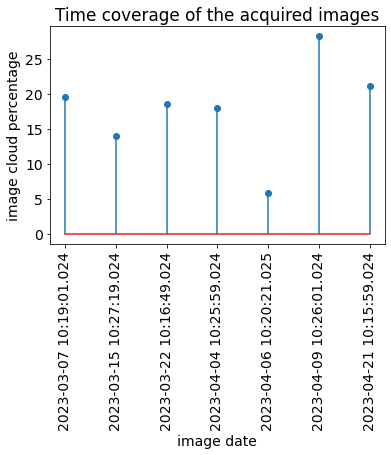

In [38]:
#%% IMAGE TIME COVERAGE AND CLOUD PERCENTAGE
plt.figure()
plt.stem(im_date,im_cloud_perc,orientation="vertical")
plt.xticks(rotation=90)
plt.xlabel('acquisition time')
plt.ylabel('cloud percentage')
plt.title('Time coverage of the acquired images')

The bands order is ['B02' 'B03' 'B04' 'B08' 'SCL']
all images (sentinel scenes) are in the 4D array im, which dimensions are: [y,x,band,scene]
clouds and snow cover are masked(see above preprocess_sentinel2_scenes)


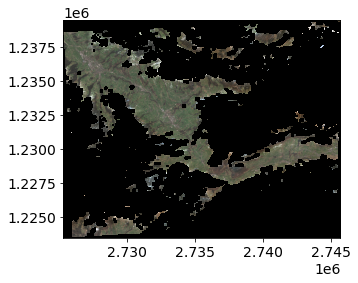

In [65]:
#%% SHOW THE FIRST RGB IMAGE
print('The bands order is ' + str(bands))
print('all images (sentinel scenes) are in the 4D array im, which dimensions are: [y,x,band,scene]')
print('clouds and snow cover are masked(see above preprocess_sentinel2_scenes)')
plt.imshow(imrisc(im[:,:,[2,1,0],0]),
           extent=[tx[0]-res/2,
                   tx[-1]+res/2,
                   ty[-1]-res/2,
                   ty[0]+res/2])
im[im==0] = np.nan

First image NDVI


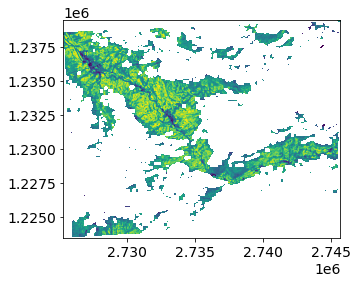

In [66]:
#%% compute NDVI for all scenes as a unique matrix operation
RED = im[:,:,2,:]
NIR = im[:,:,3,:]
NDVI = (NIR-RED)/(NIR+RED)

print('First image NDVI')
plt.imshow(imrisc(NDVI[:,:,0]),
         extent=[tx[0]-res/2,
                 tx[-1]+res/2,
                 ty[-1]-res/2,
                 ty[0]+res/2])

In [67]:
# SAVE THE NDVI DATA AS .NPZ file

np.savez("../../data/sentinel2_ndvi_array.npz",
         im_date = im_date, # dates vector
         im_cloud_perc = im_cloud_perc, # cloud pecentage vector
         im = NDVI, # images array [x,y,band,scene]
         tx = tx, # x coord vector
         ty = ty,  # y coord vector
         res = res, # grid resolution
         shp = shp # roi shapefile
         )